In [1]:
# import pandas as pd
# from pathlib import Path
# from collections import deque
# from tqdm import tqdm
# import os
# import csv

# from pipeline.aggregator import TimeframeAggregator
# from pipeline.zone_engine import ZoneEngine
# from pipeline.generate_image import ImageGenerator

# # --- Config ---
# csv_path = "./data/agg_data/fx/C:EURUSD_1m_last1y.csv"
# save_dir = Path("./dataset")
# timeframes = ["1m", "3m", "5m", "15m", "1h", "4h", "1d"]
# candle_limits = {tf: 60 for tf in timeframes}
# image_size = (640, 640)
# preload_days = 1

# # --- Setup ---
# df = pd.read_csv(csv_path, parse_dates=["timestamp"])
# buffer = deque(maxlen=10000)
# aggregator = TimeframeAggregator(buffer)
# zone_engine = ZoneEngine(timeframes)
# image_gen = ImageGenerator(candle_limits, image_size=image_size)

# # --- Preload period ---
# preload_minutes = preload_days * 24 * 60
# pbar = tqdm(total=preload_minutes, desc=f"Preloading {preload_days} days", unit="min")

# for i in range(preload_minutes):
#     if i >= len(df):
#         break
#     bar = df.iloc[i].to_dict()
#     buffer.append(bar)
#     resampled = aggregator.resample_all(timeframes)

#     for tf in timeframes:
#         df_tf = resampled[tf]
#         if len(df_tf) < candle_limits[tf]:
#             continue

#         last_bar = df_tf.iloc[-1].to_dict()
#         zone_engine.update(tf, last_bar)  # alignment handled inside ZoneEngine

#     pbar.update(1)

# pbar.close()
# print(f"[INFO] Preload complete after {preload_days} days. Starting image generation.")

# # --- Prepare meta.csv ---
# meta_path = save_dir / "meta.csv"
# os.makedirs(save_dir, exist_ok=True)

# header = ["timestamp", "close"]
# for tf in timeframes:
#     header.append(f"{tf}_img")
#     header.append(f"{tf}_lbl")

# with open(meta_path, "w", newline="") as f:
#     writer = csv.DictWriter(f, fieldnames=header)
#     writer.writeheader()

# # --- Main loop ---
# last_zones = {tf: [] for tf in timeframes}  # cache most recent zones per TF

# for i in tqdm(range(preload_minutes, len(df)), desc="Generating images"):
#     bar = df.iloc[i].to_dict()
#     buffer.append(bar)

#     resampled = aggregator.resample_all(timeframes)
#     timestamp = pd.to_datetime(df.iloc[i]["timestamp"])
#     close_price = df.iloc[i]["close"]
#     tf_image_paths = {}

#     for tf in timeframes:
#         df_tf = resampled[tf]
#         if df_tf.empty:
#             continue  # Can't do anything with empty data

#         last_candle = df_tf.iloc[-1]
#         last_ts = pd.to_datetime(last_candle["timestamp"])
#         tf_minutes = zone_engine._parse_tf_to_minutes(tf)
#         aligned_ts = timestamp.floor(f"{tf_minutes}min")

#         # Update zones only when we have enough candles AND the candle is aligned
#         if len(df_tf) >= candle_limits[tf] and last_ts == aligned_ts:
#             zone_engine.update(tf, last_candle.to_dict())
#             last_zones[tf] = zone_engine.get_visible_zones(tf)

#         # Always attempt image gen with whatever we have
#         window = df_tf.tail(min(len(df_tf), candle_limits[tf]))  # Use partial window if needed
#         earliest_ts = window["timestamp"].iloc[0]
#         latest_ts = window["timestamp"].iloc[-1]

#         filtered_zones = [
#             z for z in last_zones[tf]
#             if earliest_ts <= pd.to_datetime(z["pivot_timestamp"]) <= latest_ts
#         ]

#         img_path = save_dir / "images" / tf / f"{timestamp}.png"
#         lbl_path = save_dir / "labels" / tf / f"{timestamp}.txt"

#         image_gen.generate_image(tf, window, filtered_zones, str(img_path))

#         tf_image_paths[f"{tf}_img"] = str(img_path)
#         tf_image_paths[f"{tf}_lbl"] = str(lbl_path)

#     if tf_image_paths:
#         row = {"timestamp": timestamp, "close": close_price}
#         row.update(tf_image_paths)

#         with open(meta_path, "a", newline="") as f:
#             writer = csv.DictWriter(f, fieldnames=header)
#             writer.writerow(row)


# print(f"[✅ DONE] Meta written incrementally to {meta_path}")


In [2]:
# import os
# import glob
# import shutil

# # --- Settings ---
# SOURCE_IMAGE_DIR = "./dataset/images"
# SOURCE_LABEL_DIR = "./dataset/labels"
# OUTPUT_BASE_DIR = "./img_dataset"

# TRAIN_SPLIT = 0.7
# VAL_SPLIT = 0.2
# TEST_SPLIT = 0.1

# # --- Collect all image paths (in sorted order, not shuffled) ---
# image_paths = sorted(
#     glob.glob(f"{SOURCE_IMAGE_DIR}/**/*.png", recursive=True) +
#     glob.glob(f"{SOURCE_IMAGE_DIR}/**/*.jpg", recursive=True)
# )

# # --- Calculate split indices ---
# total = len(image_paths)
# n_train = int(total * TRAIN_SPLIT)
# n_val = int(total * VAL_SPLIT)
# n_test = total - n_train - n_val

# train_imgs = image_paths[:n_train]
# val_imgs = image_paths[n_train:n_train + n_val]
# test_imgs = image_paths[n_train + n_val:]

# splits = {
#     "train": train_imgs,
#     "val": val_imgs,
#     "test": test_imgs
# }

# # --- Copy files with timeframe in name ---
# for split, paths in splits.items():
#     for img_path in paths:
#         relative_img_path = os.path.relpath(img_path, SOURCE_IMAGE_DIR)
#         tf = relative_img_path.split(os.sep)[0]  # timeframe (e.g. "1h")

#         # Base name like "2024-09-30 09:01:00.png"
#         filename = os.path.basename(img_path)

#         # Prefix or suffix TF to filename (choose one)
#         new_filename = f"{tf}_{filename}"

#         # Output dirs
#         img_out_dir = os.path.join(OUTPUT_BASE_DIR, "images", split)
#         lbl_out_dir = os.path.join(OUTPUT_BASE_DIR, "labels", split)
#         os.makedirs(img_out_dir, exist_ok=True)
#         os.makedirs(lbl_out_dir, exist_ok=True)

#         # Copy image
#         shutil.copy(img_path, os.path.join(img_out_dir, new_filename))

#         # Label path logic
#         label_rel_path = os.path.splitext(relative_img_path)[0] + ".txt"
#         label_full_path = os.path.join(SOURCE_LABEL_DIR, label_rel_path)

#         if os.path.exists(label_full_path):
#             new_label_name = os.path.splitext(new_filename)[0] + ".txt"
#             shutil.copy(label_full_path, os.path.join(lbl_out_dir, new_label_name))
#         else:
#             print(f"⚠️ Label not found for: {img_path}")

# print("✅ Dataset split complete. Filenames now include timeframe.")
# print(f"Total: {total} | Train: {len(train_imgs)} | Val: {len(val_imgs)} | Test: {len(test_imgs)}")


INFO:env.trading_env:[ENV INIT] Loaded meta with 8886 rows. Starting at index 0


🔍 Image paths used for YOLO encoding:
1m: dataset/images/1m/2024-09-27 00:00:00.png
3m: dataset/images/3m/2024-09-27 00:00:00.png
5m: dataset/images/5m/2024-09-27 00:00:00.png
15m: dataset/images/15m/2024-09-27 00:00:00.png
1h: dataset/images/1h/2024-09-27 00:00:00.png
4h: dataset/images/4h/2024-09-27 00:00:00.png
1d: dataset/images/1d/2024-09-27 00:00:00.png


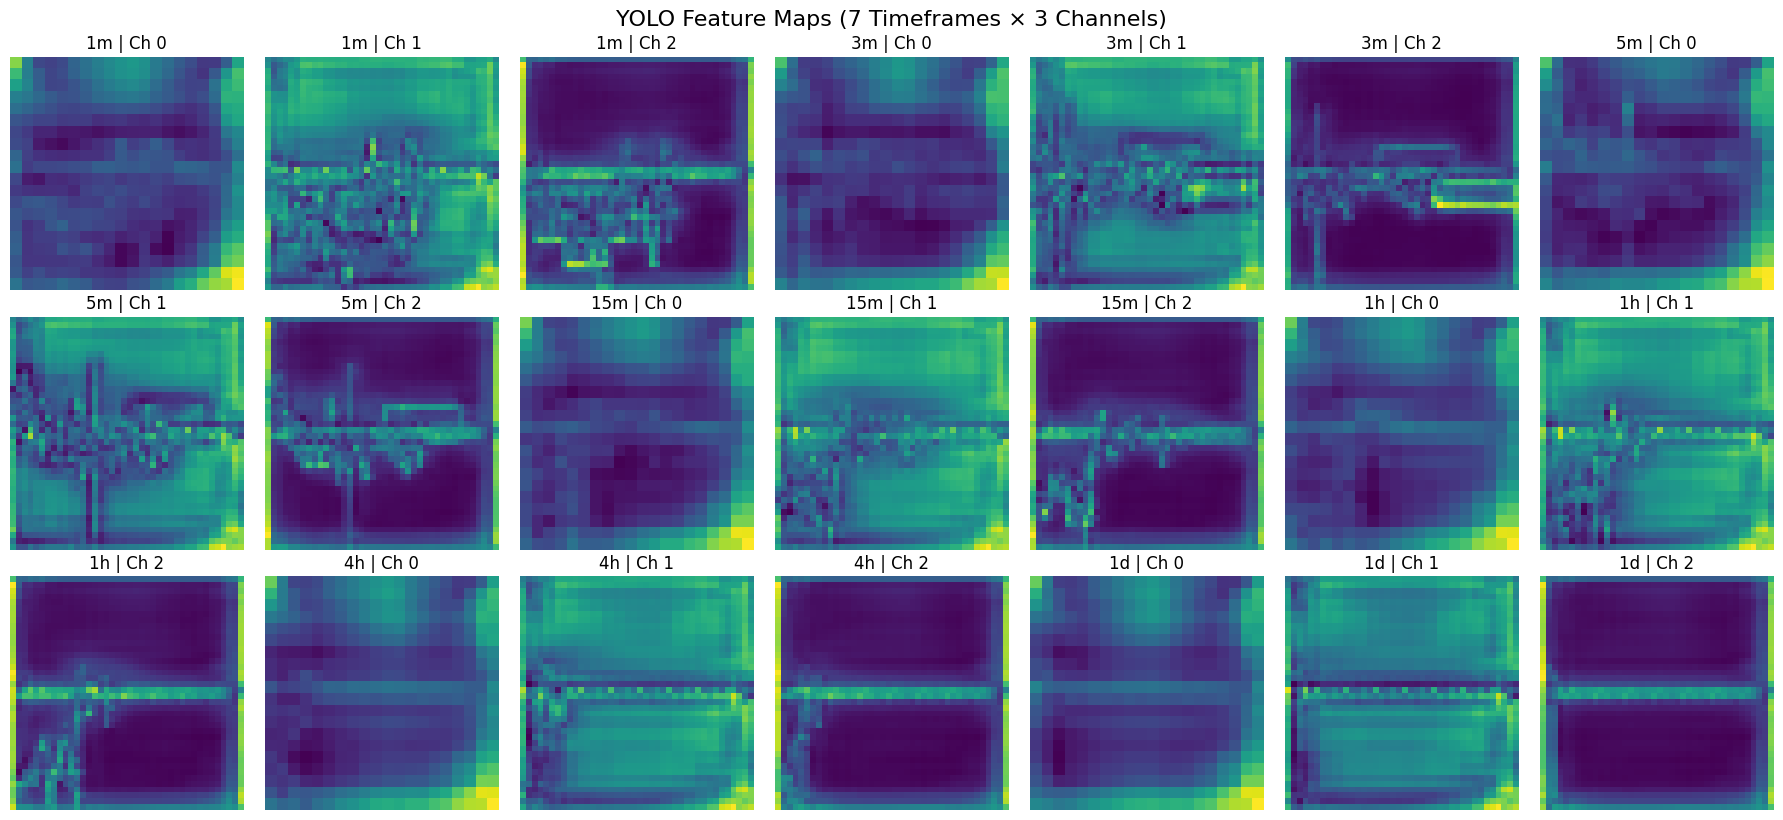

In [7]:
import torch
import matplotlib.pyplot as plt
from env.trading_env import TradingEnv
from models.yolo_encoder import YOLOEncoder
import pandas as pd

# --- Setup ---
meta_df = pd.read_csv("./dataset/meta.csv", parse_dates=["timestamp"])
env = TradingEnv(meta_df)
obs, _ = env.reset()

# Print the image paths used for the current observation
print("🔍 Image paths used for YOLO encoding:")
row = env.meta_df.iloc[env.current_index]  # current_index = 60 typically
for tf in env.timeframes:
    path = row.get(f"{tf}_img", "N/A")
    print(f"{tf}: {path}")

# Convert obs to torch tensors
images = torch.tensor(obs["images"]).unsqueeze(0)  # [1, 7, 3, H, W]
images = images.float()

# Load YOLO encoder
encoder = YOLOEncoder(model_path="./models/runs/yolo_run_5/weights/best.pt")

# --- Process each image through YOLO encoder ---
encoded = []
with torch.no_grad():
    for i in range(7):  # 7 timeframes
        out = encoder(images[:, i])  # [1, 3, H', W']
        encoded.append(out)

# Concatenate: [1, 21, H, W]
features = torch.cat(encoded, dim=1).squeeze(0)  # [21, H, W]

# --- Plot all 21 feature maps ---
fig, axes = plt.subplots(3, 7, figsize=(18, 8))
timeframes = env.timeframes  # ["1m", "3m", ..., "1d"]

for i, ax in enumerate(axes.flat):
    fmap = features[i].cpu().numpy()
    fmap -= fmap.min()
    fmap /= (fmap.max() + 1e-8)

    tf_idx = i // 3
    ch_idx = i % 3
    tf_label = timeframes[tf_idx]

    ax.imshow(fmap, cmap="viridis")
    ax.set_title(f"{tf_label} | Ch {ch_idx}")
    ax.axis("off")

plt.tight_layout()
plt.suptitle("YOLO Feature Maps (7 Timeframes × 3 Channels)", fontsize=16, y=1.02)
plt.show()


In [8]:
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from env.trading_env import TradingEnv
from models.yolo_extractor import CustomYOLOPolicy

# --- Load your meta.csv ---
meta_df = pd.read_csv("./dataset/meta.csv", parse_dates=["timestamp"])

# --- Create your environment ---
def make_env():
    return TradingEnv(meta_df)

# Wrap in a vectorized env (even with 1 env, SB3 expects this)
vec_env = make_vec_env(make_env, n_envs=1)

# --- Create PPO model ---
model = PPO(
    policy=CustomYOLOPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    ent_coef=0.01,
    tensorboard_log="./logs"
)

# --- Train the model ---
model.learn(total_timesteps=100)

# --- Save it ---
model.save("ppo-yolo-trading")
print("✅ Training complete. Model saved to: ppo-yolo-trading")


INFO:env.trading_env:[ENV INIT] Loaded meta with 8886 rows. Starting at index 0


Using cpu device
Logging to ./logs/PPO_5
---------------------------
| time/              |    |
|    fps             | 1  |
|    iterations      | 1  |
|    time_elapsed    | 52 |
|    total_timesteps | 64 |
---------------------------


KeyboardInterrupt: 